In [41]:
from folktables import ACSDataSource, ACSEmployment, ACSIncome
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

# local libraries
import metrics as mt

In [3]:
clf_dict = {'LR':LogisticRegression, 
           'GB':GradientBoostingClassifier}
data_dict={}

In [61]:
state='SD'
data_dict[state] = {}
for year in ['2014', '2015', '2016', '2017', '2018']: 
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [22]:
np.unique(data_dict[state][year]['g'], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4249,   43,  296,    1,   23,   33,    3,   21,   78]))

In [42]:
# acoss years
results = [] 
for clf in clf_dict: 
    for i in range(5): 
        year = '2014'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.2, random_state=i)

        model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test) 

        results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
        })
        for year in data_dict[state].keys(): 
            
            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[state][year]['x'],
                    data_dict[state][year]['y'], 
                    data_dict[state][year]['g'], test_size=0.4, random_state=i)
            yhat = model.predict(X_test)
            corr = yhat == y_test
            
            g_acc_arr = mt.group_accuracy(corr, group_test)
        
            results.append({
            'year': year, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
            'clf': clf,
        })

Text(0.5, 0.98, 'SD Model across different years trained on 2014')

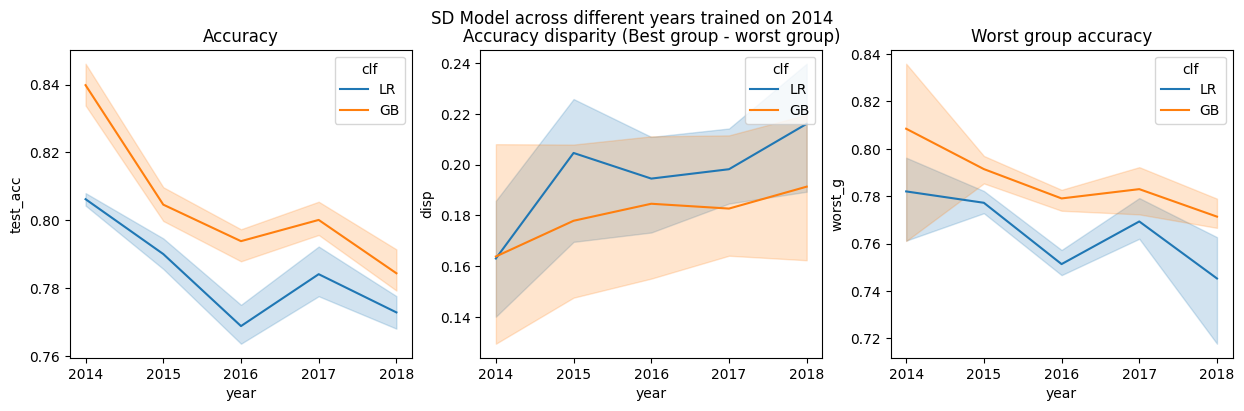

In [43]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='year', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x='year', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x='year', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model across different years trained on 2014")

In [ ]:
data_dict={}
state='KS'
year='2014'

for state in ['CA', 'HI', 'SD', 'PA', 'MI', 'GA', 'MS']: 
    data_dict[state] = {}
    data_source = ACSDataSource(survey_year=year, horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True)
    data_dict[state][year] = {}
    features, label, group = ACSIncome.df_to_numpy(acs_data)
    data_dict[state][year]['x'] = features
    data_dict[state][year]['y'] = label
    data_dict[state][year]['g'] = group 

In [47]:
# acoss states
results = [] 
year='2014'
for clf in clf_dict: 
    for i in range(5): 
        ref_state = 'CA'
        X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                    data_dict[ref_state][year]['x'],
                    data_dict[ref_state][year]['y'], 
                    data_dict[ref_state][year]['g'], test_size=0.2, random_state=i)

        model = make_pipeline(StandardScaler(), clf_dict[clf]())

        model.fit(X_train, y_train)
        
        yhat = model.predict(X_test)
        corr = yhat == y_test
        g_acc_arr = mt.group_accuracy(corr, group_test) 

        results.append({
            'year': year, 
            'state': ref_state, 
            'test_acc': model.score(X_test, y_test), 
            'disp': max(g_acc_arr) - min(g_acc_arr), 
            'worst_g': min(g_acc_arr), 
            'size': len(y_train), 
            'run': i, 
            'clf': clf,
        })
        for state in data_dict.keys(): 
            if state != ref_state: 
                X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                        data_dict[state][year]['x'],
                        data_dict[state][year]['y'], 
                        data_dict[state][year]['g'], test_size=0.4, random_state=i)
                yhat = model.predict(X_test)
                corr = yhat == y_test
                g_acc_arr = mt.group_accuracy(corr, group_test) 

                results.append({
                'year': year, 
                'state': state, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr), 
                'worst_g': min(g_acc_arr), 
                'size': len(y_train), 
                'run': i, 
                'clf': clf,
            })

Text(0.5, 0.98, '2014 CA model on other states')

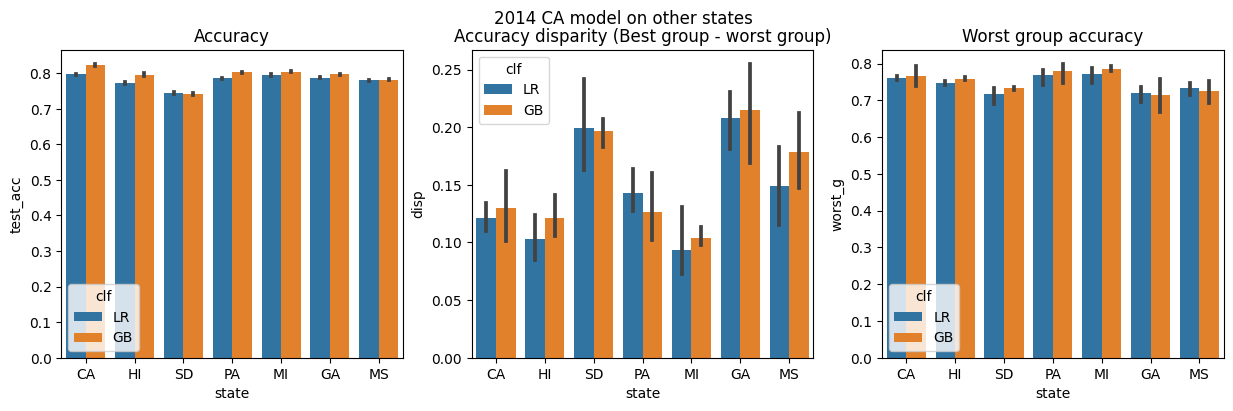

In [49]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=results_df, x='state', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.barplot(data=results_df, x='state', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.barplot(data=results_df, x='state', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"2014 {ref_state} model on other states")

In [54]:
results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000]
for clf in clf_dict.keys(): 
    for size in size_arr: 
        print(size)
        for run in range(5): 
            

            X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
                data_dict[state][year]['x'], 
                data_dict[state][year]['y'], 
                data_dict[state][year]['g'], test_size=0.2, random_state=0)
            
            incl = np.asarray(random.sample(range(len(y_train)), size))
            
            X_train = X_train[incl]
            y_train = y_train[incl]
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_train, y_train)
            
            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)

            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'test_acc': model.score(X_test, y_test), 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

50
100
500
1000
2000
50
100
500
1000
2000


Text(0.5, 0.98, 'SD Model with increasing datasize')

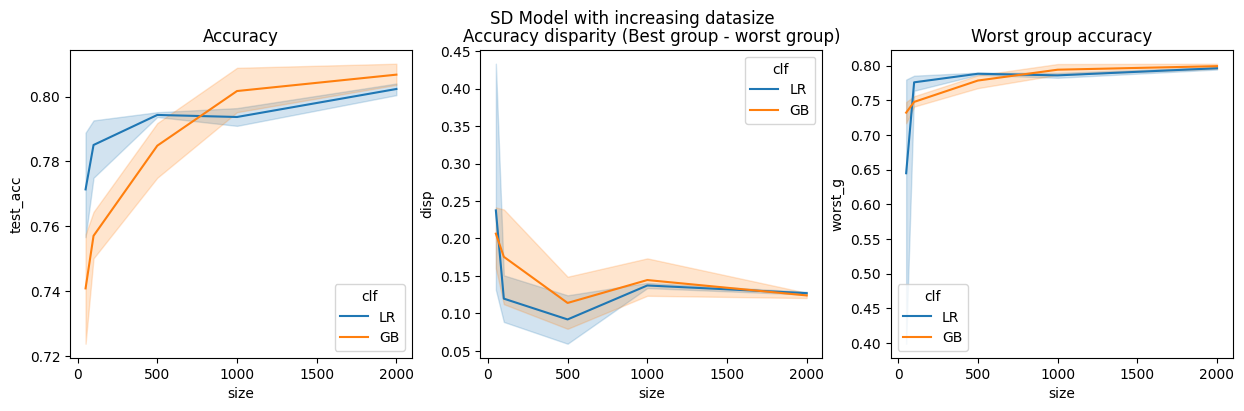

In [55]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].set_title("Accuracy")
sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
plt.suptitle(f"{state} Model with increasing datasize")

In [56]:
# sequential

results = [] 
state='SD'
year='2014'
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000, 12000, 14000]
for run in range(5): 
    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]['x'], 
        data_dict[state][year]['y'], 
        data_dict[state][year]['g'], test_size=0.2, random_state=run)

    X_joint = np.concatenate((X_train, 
                            data_dict['CA'][year]['x']))
    y_joint = np.concatenate((y_train, 
                            data_dict['CA'][year]['y']))
    g_joint = np.concatenate((group_train, 
                            data_dict['CA'][year]['g']))

    for clf in clf_dict.keys(): 

        for size in size_arr: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)


            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

Text(0.5, 0.98, 'SD Model with increasing datasize')

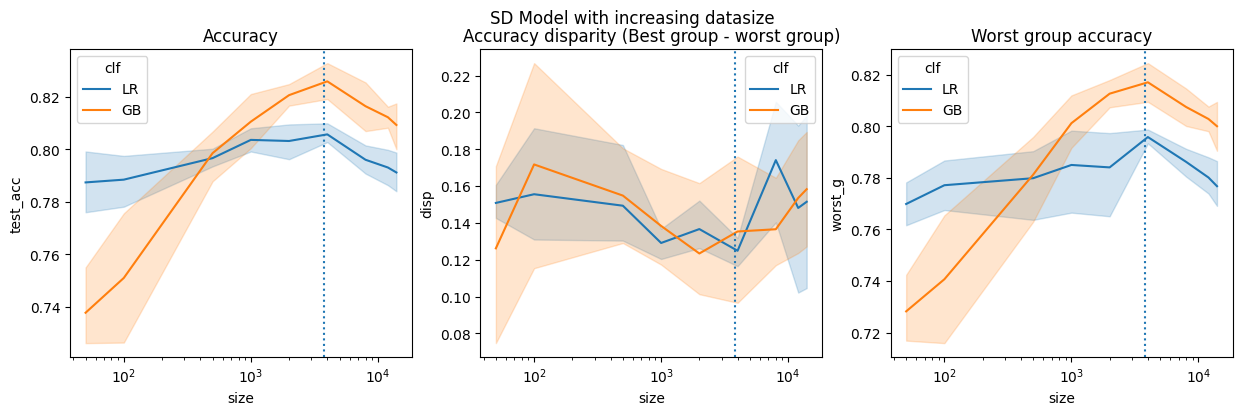

In [59]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=':')
axes[0].set_xscale('log')
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=':')
axes[1].set_xscale('log')

sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=':')
axes[2].set_xscale('log')
plt.suptitle(f"{state} Model with increasing datasize")

In [ ]:
results = [] 
state='SD'
year='2018'
train_year = '2014'
size_arr = [50, 100, 500, 1000, 2000, 4000, 8000]
for run in range(5): 

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        data_dict[state][year]['x'], 
        data_dict[state][year]['y'], 
        data_dict[state][year]['g'], test_size=0.2, random_state=run)

    X_joint = np.concatenate((X_train, 
                            data_dict[state][train_year]['x']))
    y_joint = np.concatenate((y_train, 
                            data_dict[state][train_year]['y']))
    g_joint = np.concatenate((group_train, 
                            data_dict[state][train_year]['g']))

    for clf in clf_dict.keys(): 

        for size in size_arr: 
            model = make_pipeline(StandardScaler(), clf_dict[clf]())

            model.fit(X_joint[:size], y_joint[:size])

            yhat = model.predict(X_test)
            corr = yhat == y_test
            g_acc_arr = mt.group_accuracy(corr, group_test)

            train_acc = model.score(X_train, y_train)

            test_acc = model.score(X_test, y_test)


            results.append({
                'train_acc': train_acc, 
                'test_acc': test_acc, 
                'disp': max(g_acc_arr) - min(g_acc_arr),
                'worst_g': min(g_acc_arr), 
                'size': size, 
                'run': run, 
                'clf': clf, 
            })

In [ ]:
results_df = pd.DataFrame(results)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=results_df, x='size', y='test_acc', hue='clf', ax=axes[0])
axes[0].axvline(x=len(X_train), linestyle=':')
axes[0].set_xscale('log')
axes[0].set_title("Accuracy")

sns.lineplot(data=results_df, x='size', y='disp', hue='clf', ax=axes[1])
axes[1].set_title("Accuracy disparity (Best group - worst group)")
axes[1].axvline(x=len(X_train), linestyle=':')
axes[1].set_xscale('log')

sns.lineplot(data=results_df, x='size', y='worst_g', hue='clf', ax=axes[2])
axes[2].set_title("Worst group accuracy")
axes[2].axvline(x=len(X_train), linestyle=':')
axes[2].set_xscale('log')
plt.suptitle(f"Model with increasing datasize")